# Load Data and Packages

In [ ]:
!pip install rdkit-pypi
!pip install bayesian-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 13.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import xgboost as xgb

# Data Preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import Pipeline

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, auc, precision_score, recall_score, average_precision_score
from bayes_opt import BayesianOptimization
from imblearn.over_sampling import SMOTE

df = pd.read_csv('drugData_jan-2024.csv')
smiles_list = df['smiles'].tolist()

In [ ]:
def smiles_to_mol(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            raise ValueError(f"Invalid SMILES string: {smiles}")
        return mol
    except Exception as e:
        print(e)
        return None

molecules = [smiles_to_mol(smiles) for smiles in smiles_list]
molecules = [mol for mol in molecules if mol is not None]
fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048) for mol in molecules]
df['fingerprint'] = fingerprints
df = df.drop('smiles', axis=1)

X = np.array(list(df['fingerprint']))
y = df['label']
y = np.array(y)
np.shape(X)
display(X)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Training and Optimization

In [ ]:
def xgb_eval(n_estimators, eta, max_depth, min_child_weight, scale_pos_weight, subsample, colsample_bytree, max_delta_step, X_train, y_train, X_test, y_test):
  n_estimators = int(n_estimators)
  max_depth = int(max_depth)
  subsample = max(0, min(1, subsample))
  colsample_bytree = max(0.5, min(1, colsample_bytree))
  min_child_weight = int(min_child_weight)

  params = {
      'n_estimators': n_estimators,
      'eta': eta,
      'max_depth': max_depth,
      'min_child_weight': min_child_weight,
      'scale_pos_weight': scale_pos_weight,
      'subsample': subsample,
      'colsample_bytree': colsample_bytree,
      'max_delta_step': max_delta_step,
      'eval_metric':'aucpr',
      'objective': 'binary:logistic',
      'use_label_encoder':False,
  }

  model = xgb.XGBClassifier(**params)
  model.fit(X_train, y_train)
  y_pred_proba = model.predict_proba(X_test)[:, 1]

  precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
  pr_auc = auc(recall, precision)

  return pr_auc

param_bounds = {
    'n_estimators': (50, 1000),
    'eta': (0.01, 0.1),
    'max_depth': (3, 7),
    'min_child_weight': (1, 10),
    'scale_pos_weight':(9, 11),
    'subsample': (0.6, 0.9),
    'colsample_bytree': (0.6, 0.9),
    'max_delta_step': (0, 1),
}

|   iter    |  target   | colsam... |    eta    | max_de... | max_depth | min_ch... | n_esti... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 3         | 0.1709    | 0.6913    | 0.05723   | 0.4319    | 4.165     | 6.507     | 182.5     | 9.584     | 0.7099    |
| 4         | 0.1726    | 0.7368    | 0.08067   | 0.1997    | 5.057     | 6.332     | 94.13     | 10.22     | 0.6512    |
| 5         | 0.1745    | 0.6195    | 0.0954    | 0.9656    | 6.234     | 3.742     | 142.8     | 10.37     | 0.732     |
| 7         | 0.1953    | 0.764     | 0.02664   | 0.9696    | 6.101     | 9.455     | 900.1     | 10.2      | 0.8766    |
| 17        | 0.2219    | 0.6833    | 0.09084   | 0.4671    | 4.569     | 7.515     | 914.1     | 9.05      | 0.7345    |
|   iter    |  target   | colsam... |    eta    | max_de... | max_depth | min_ch... | n_esti... | scale_... | subsample |
------------------------

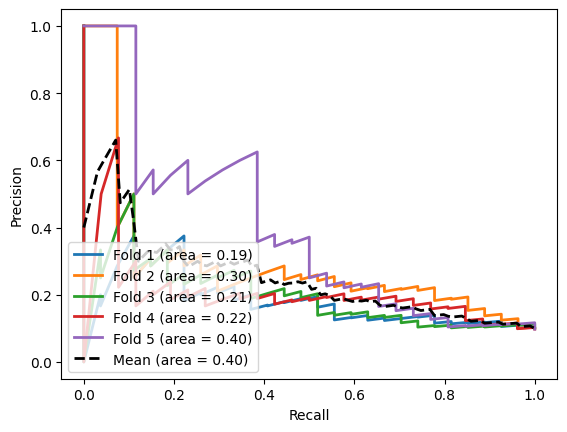

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

precision_values = []
recall_values = []
average_precisions = []
fprs = []
tprs = []

for fold_idx, (train_index, test_index) in enumerate(kf.split(X, y)):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]


  smote = SMOTE(random_state=42)
  X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


  def xgb_eval_curr(n_estimators, eta, min_child_weight, scale_pos_weight, max_depth, max_delta_step, subsample, colsample_bytree):
    return xgb_eval(n_estimators, eta, min_child_weight, scale_pos_weight, max_depth, max_delta_step, subsample, colsample_bytree, X_train_res, y_train_res, X_test, y_test)

# Hyperparameter Optimization
  optimizer = BayesianOptimization(f=xgb_eval_curr, pbounds=param_bounds, random_state=42, verbose=1)
  optimizer.maximize(init_points=16, n_iter=2)

# Store best parameters
  best_params = optimizer.max['params']
  best_params['max_depth'] = int(best_params['max_depth'])
  best_params['n_estimators'] = int(best_params['n_estimators'])
  best_params['min_child_weight'] = int(best_params['min_child_weight'])
  best_params['subsample'] = max(0, min(1, best_params['subsample']))
  best_params['colsample_bytree'] = max(0.5, min(1, best_params['colsample_bytree']))

  params = {
      'eta':best_params['eta'],
      'max_depth': best_params['max_depth'],
      'scale_pos_weight': best_params['scale_pos_weight'],
      'subsample': best_params['subsample'],
      'colsample_bytree': best_params['colsample_bytree'],
      'max_delta_step': best_params['max_delta_step'],
      'eval_metric': 'aucpr',
      'objective': 'binary:logistic',
      'use_label_encoder': False

  }


  dtrain = xgb.DMatrix(X_train, label=y_train)
  dtest = xgb.DMatrix(X_test, label=y_test)
  num_rounds=100

  bst = xgb.train(best_params, dtrain, num_rounds)
  y_pred_prob = bst.predict(dtest)

  precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
  average_precision = average_precision_score(y_test, y_pred_prob)

  fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
  roc_auc = roc_auc_score(y_test, y_pred_prob)

  # AUC values for each graph
  fprs.append(np.interp(np.linspace(0, 1, 100), fpr, tpr))
  tprs.append(np.linspace(0, 1, 100))

  # Store PR values for the graph
  precision_values.append(np.interp(np.linspace(0, 1, 100), recall[::-1], precision[::-1]))
  recall_values.append(np.linspace(0, 1, 100))
  average_precisions.append(average_precision)

  plt.plot(recall, precision, lw=2, label=f'Fold {fold_idx+1} (area = {average_precision:.2f})')

mean_precision = np.mean(precision_values, axis=0)
mean_recall = np.mean(recall_values, axis=0)
mean_fpr = np.mean(fprs, axis=0)
mean_tpr = np.mean(tprs, axis=0)

mean_average_precision = np.mean(average_precision)
print(f"Mean Average Precision: {mean_average_precision:.2f}")

plt.plot(mean_recall, mean_precision, 'k--', lw=2, label = f'Mean (area = {mean_average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.show()




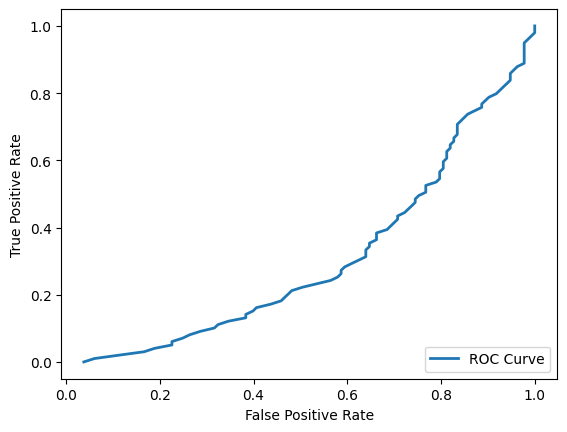

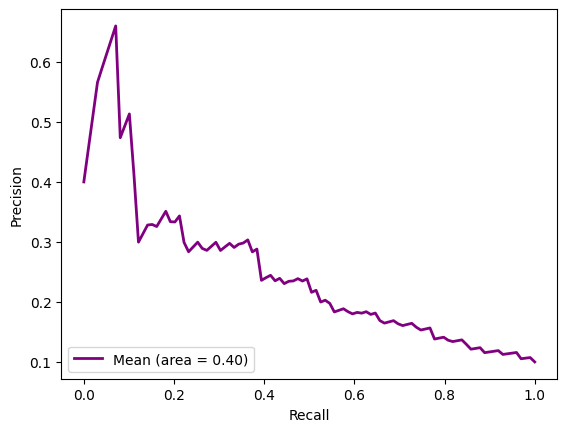

In [ ]:
plt.plot(mean_fpr, mean_tpr, lw=2, label='ROC Curve')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


plt.plot(mean_recall, mean_precision, lw=2, color="purple", label = f'Mean (area = {mean_average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.show()

In [ ]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

plt.figure(figsize=(10, 8))

for fold_idx, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    num_rounds = 280

    bst = xgb.train(best_params, dtrain, num_rounds)

    y_pred_prob = bst.predict(dtest)

    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    average_precision = average_precision_score(y_test, y_pred_prob)

    plt.plot(recall, precision, lw=2, label=f'Fold {fold_idx+1} (area = {average_precision:.2f})')


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="upper right")
plt.show()

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


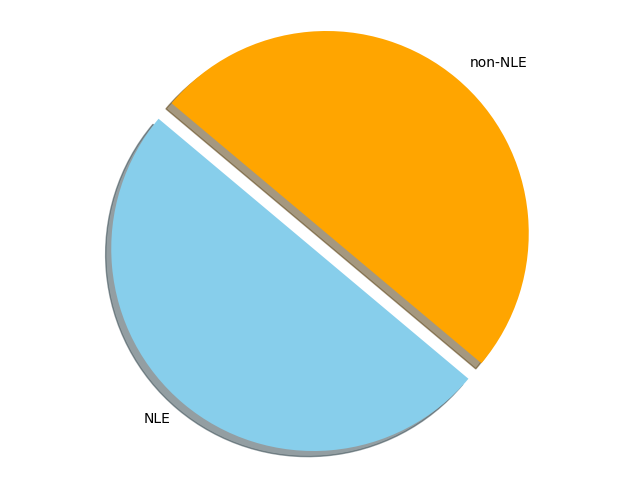

In [ ]:
import matplotlib.pyplot as plt

# Define data for the pie chart
sizes = [50, 50]
colors = ['skyblue', 'orange']
explode = (0.1, 0)  # explode the 1st slice (Class 0)

# Create the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        shadow=True, startangle=140)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()
